# Logistic regression on blood transfusion data

This working notebook is to try logistic regression model to predict if a blood donor will donate again within given time and what is the relationship between the variables and the target.

Data is from from the Blood Transfusion Service Center in Hsin-Chu City in Taiwan and can be downloaded from UCI Machine Learning Repository http://archive.ics.uci.edu/ml

In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import scikitplot as skplt #pip install scikit-plot

In [2]:
columns = ['R', 'F', 'M', 'T', 'a']
raw_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data',
                #names = columns,
                #index_col = False,
                skipinitialspace=True)

raw_data.head()

#R (Recency - months since last donation),
#F (Frequency - total number of donation),
#M (Monetary - total blood donated in c.c.),
#T (Time - months since first donation)
#a binary variable representing whether he/she donated blood in March 2007 (1 - yes, 0 - no)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [4]:
data = raw_data.copy()

In [5]:
data.columns = ['recency', 'frequency', 'monetary', 'time', 'target']

In [6]:
sum(data['target'])/len(data)

#incidence is not very low!

0.23796791443850268

## Logistic regression model

In [7]:
#dataframe X with cadidate predictors only
independent = ['recency', 'frequency', 'monetary', 'time']
x = data[independent]

#dataframe with target #values = numoy array #ravel = flatten, convert to (n, )
y = data[['target']].values.ravel()

#model & fit to data
logreg = linear_model.LogisticRegression()
logreg.fit(x, y)

#coefficients & intercept
coef = logreg.coef_
for p,c in zip(independent,list(coef[0])):
    print(p + '\t' + str(c))
    
intercept = logreg.intercept_
print(intercept)

recency	-0.09855504818175743
frequency	2.1662954778041675e-06
monetary	0.0005415738692981355
time	-0.023094135809504084
[-0.44970589]


In [8]:
#make predictions based on given independent variables
#new sample data
new_data = pd.DataFrame([[3, 12, 3000, 70]], columns = ['recency',	'frequency', 'monetary', 'time'])

#predict
pred = logreg.predict_proba(new_data)
print(pred)

#probability of 0, probability of 1

[[0.6763861 0.3236139]]


## Selecting variables

In [9]:
#AUC to check the model, how well a model can order observations from low to high probability to be target
#make predictions from the original set
predictions = logreg.predict_proba(x)
pred_target = predictions[:,1]

#true target and predictions
auc = roc_auc_score(y, pred_target)
print(round(auc,2))

0.75


In [10]:
#checking score from two sets of variables
set_1 = ['recency', 'frequency']
set_2 = ['monetary', 'time']

x_1 = data[set_1]
x_2 = data[set_2]

logreg = linear_model.LogisticRegression()

logreg.fit(x_1, y)
pred_1 = logreg.predict_proba(x_1)[:,1]
auc_1 = roc_auc_score(y, pred_1)

logreg.fit(x_2, y)
pred_2 = logreg.predict_proba(x_2)[:,1]
auc_2 = roc_auc_score(y, pred_2)

# Print auc_1 and auc_2
print(round(auc_1,2))
print(round(auc_2,2))

0.74
0.72


Forward stepwise variable selection

In [11]:
#function: calculate AUC for a given variable set that the model uses

def auc(variables, target, df):    
    #input
    X = df[variables]    
    y = df[target].values.ravel()    
    #prediction
    logreg = linear_model.LogisticRegression()    
    logreg.fit(X, y)    
    #auc
    predictions = logreg.predict_proba(X)[:,1]    
    auc = roc_auc_score(y, predictions)
    return(auc)

In [12]:
auc_1 = auc(['recency','frequency'],['target'],data)
print(auc_1)

0.7351271437019515


In [108]:
#function: next best variable in combination with current variable

def next_best(current_variables, candidate_variables, target, df):
    best_auc = -1
    best_var = []
    #auc for each variable in set
    for v in candidate_variables:
        auc_v = auc (current_variables + [v], target, df)
        #if better than auc so far then replace
        if auc_v >= best_auc:
            best_auc = auc_v
            best_var = v
    return best_var

In [14]:
current_var = ['recency']
candidate_var = ['monetary', 'frequency']

next_variable = next_best(current_var, candidate_var, ['target'], data)

print(next_variable)

frequency


In [15]:
#selection procedure

#empty set and add one by one
candidate_var = list(data.columns.values)
candidate_var.remove('target')

current_var = []

#max no of variables that can be added:
max_var = 3

#iterations:
no_of_iterations = min(max_var, len(candidate_var)) #3

#current variable list:
for i in range(0, no_of_iterations):
    next_var = next_best(current_var, candidate_var, ['target'], data)
    current_var = current_var + [next_var]
    candidate_var.remove(next_var)
    print("Variable added in step " + str(i+1)  + " is " + next_var + ".")
print(current_var)

Variable added in step 1 is recency.
Variable added in step 2 is monetary.
Variable added in step 3 is time.
['recency', 'monetary', 'time']


In [16]:
#del current_var

In [17]:
#check correlation
correlation = np.corrcoef(data["time"], data["frequency"])[0,1]
correlation

0.6349402703229293

In [18]:
#decide on number of variables & overfitting

#check on test data
x = data.drop('target', axis = 1) #x = data.drop('target', inplace = True, axis = 1) #inplace modifies the underlying data
y = data['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, 
                                                    random_state=11, #seed
                                                    stratify = y)

#final train & test df
train_df = pd.concat([x_train, y_train], axis=1)
test_df = pd.concat([x_test, y_test], axis=1)

#confirm stratify - same target % in both

#print(round(sum(train_df['target'])/len(train_df), 2))
#print(round(sum(test_df['target'])/len(test_df), 2))

variables = ['recency',	'frequency', 'monetary', 'time']
target = ['target']

auc_train = auc(variables , target, train_df)
auc_test = auc(variables , target, test_df)

print(round(auc_train,2))
print(round(auc_test,2))

#test auc < train auc --> overfitting

0.78
0.71


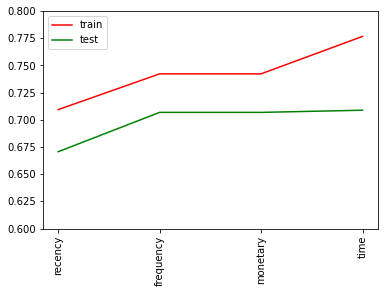

In [19]:
#AUC curves

#values at each iteration
auc_values_train = []
auc_values_test = []
#evaluated variables
variables_evaluate = []

for v in variables:
    #add the variable
    variables_evaluate.append(v)
    
    auc_train = auc(variables_evaluate, target, train_df)
    auc_test = auc(variables_evaluate , target, test_df)
    
    # Append the values
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)

    
#plot
x = np.array(range(0,len(auc_values_train)))
auc_y_train = np.array(auc_values_train)
auc_y_test = np.array(auc_values_test)
plt.xticks(x, variables, rotation = 90)
plt.plot(x, auc_y_train, label = 'train', color = 'red')
plt.plot(x, auc_y_test, label = 'test', color = 'green')
plt.legend(loc="upper left")
plt.ylim((0.6, 0.8))
plt.show()

#when test AUC does not increase & better to have less complex models

## Visualizing model performance

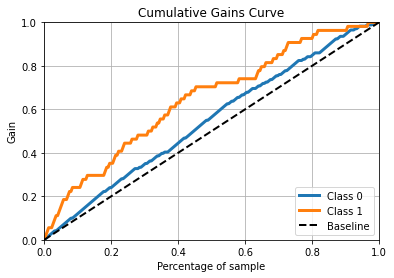

In [20]:
#see how model responds to data
#cumulative gains curve - % of targets reached considering a certain & of population with the highest probability to be target
#https://scikit-plot.readthedocs.io/en/stable/metrics.html

logreg.fit(x_train, y_train)
predicted_probs_test = logreg.predict_proba(x_test)

skplt.metrics.plot_cumulative_gain(y_test, predicted_probs_test)
plt.show()

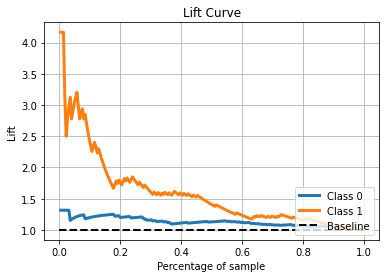

In [21]:
#lift curve
#how many times more than average the model reaches targets when given % percentage of the population most likely to be target

skplt.metrics.plot_lift_curve(y_test, predicted_probs_test)
plt.show()

Predictor Insight - graphical representation of the relation between variable & target

In [46]:
#discretizing continuous variables
#single variable:
data['monetary_bin'] = pd.qcut(data['monetary'], 6 #split into 6 bins #pd.cut if want to specify bins
                        , duplicates = 'drop')

#check if bins are similar in size
print(data.groupby('monetary_bin').size())

monetary_bin
(249.999, 500.0]     270
(500.0, 1000.0]      149
(1000.0, 1500.0]     114
(1500.0, 2250.0]      98
(2250.0, 12500.0]    117
dtype: int64


In [64]:
#data.drop(['monetary_bins'], axis=1)
df = data.copy()

#discretizing continuous variables
#multiple variables:

#variables except target
variables = list(df.columns)
variables.remove('target')

for variable in variables:
    if len(df.groupby(variable))>5:
        new_variable = "disc_" + variable
        df[new_variable] = pd.qcut(df[variable], 5, duplicates = 'drop')

print(df.columns)

Index(['recency', 'frequency', 'monetary', 'time', 'target', 'monetary_bins',
       'monetary_bin', 'disc_recency', 'disc_frequency', 'disc_monetary',
       'disc_time'],
      dtype='object')


In [65]:
#prepare a table for plotting with: intervals, avg, size of the group

#what table should look like:
data_monetary = data[['monetary_bin','target']] 

groups = data_monetary.groupby('monetary_bin') #group by bins
incidence = groups['target'].agg(avg_target = 'mean').reset_index() #avg incidence rate in each group

print(incidence)
#the higher total blood donated the higher avg incident rate

        monetary_bin  avg_target
0   (249.999, 500.0]    0.144444
1    (500.0, 1000.0]    0.181208
2   (1000.0, 1500.0]    0.324561
3   (1500.0, 2250.0]    0.316327
4  (2250.0, 12500.0]    0.376068


In [66]:
#function to create predictor insight graph table

def create_pig_table(df, target, variable):
    groups = df[[target,variable]].groupby(variable)
    pig_table = groups[target].agg(incidence = 'mean', size = 'size').reset_index()
    return pig_table

#create_pig_table(data, "target", "monetary_bin")

In [75]:
#dictionary to create table for many variables at once
pig_tables = {}

variables = ['disc_recency', 'disc_frequency', 'disc_monetary', 'disc_time']

#loop
for variable in variables:
    #create a table
    pig_table = create_pig_table(df, 'target', variable)
    #add to the dictionary
    pig_tables[variable] = pig_table #dictionary["key"] = value

print(pig_tables['disc_time'])

       disc_time  incidence  size
0  (1.999, 14.0]   0.240223   179
1   (14.0, 23.0]   0.223881   134
2   (23.0, 35.0]   0.277778   144
3   (35.0, 57.0]   0.268966   145
4   (57.0, 98.0]   0.178082   146


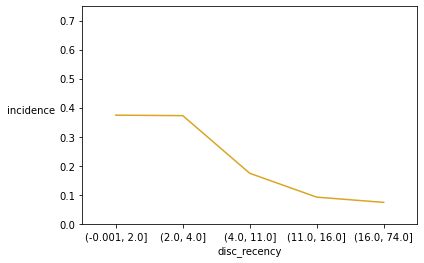

In [94]:
#function to plot target line only

def plot_incidence(pig_table, variable):
    #plot target line
    pig_table['incidence'].plot(color = 'goldenrod') #plot()
    
    plt.xticks(np.arange(len(pig_table)), pig_table[variable])
    plt.xlim([-0.5, len(pig_table) - 0.5])
    plt.ylim([0, max(pig_table['incidence'] * 2)])
    plt.ylabel('incidence', rotation = 0, rotation_mode='anchor', ha='right')
    plt.xlabel(variable)

    plt.show()

#check
plot_incidence(pig_tables['disc_recency'], 'disc_recency')

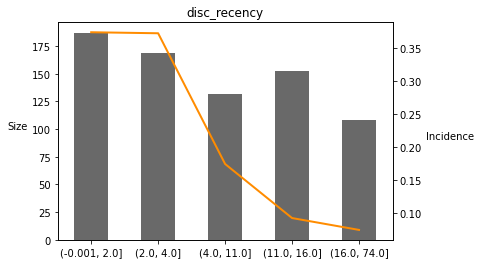

In [106]:
#function to plot target line & size bar

def plot_pig(pig_table, variable):
    #plot bars
    plt.ylabel('Size', rotation=0, rotation_mode='anchor', ha='right')
    
    pig_table['size'].plot(kind="bar", width=0.5, color='dimgrey', edgecolor="none") 
    
    #plot target line on secondary axis
    pig_table['incidence'].plot(secondary_y = True, color = 'darkorange', linewidth = 2)

    plt.xticks(np.arange(len(pig_table)), pig_table[variable])
    plt.xlim([-0.5, len(pig_table) - 0.5])
    plt.ylabel('Incidence', rotation=0, rotation_mode='anchor', ha='left')

    plt.title(variable)
    
    plt.show()
    
#check
plot_pig(pig_tables['disc_recency'], 'disc_recency')
#th higher months since last donation the lower target incidence

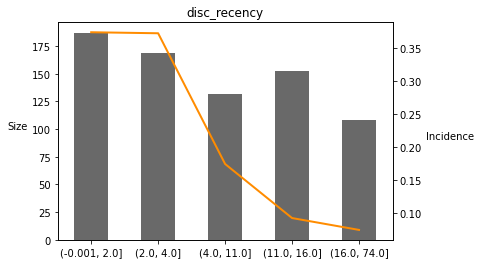

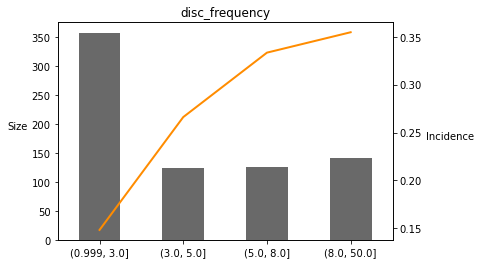

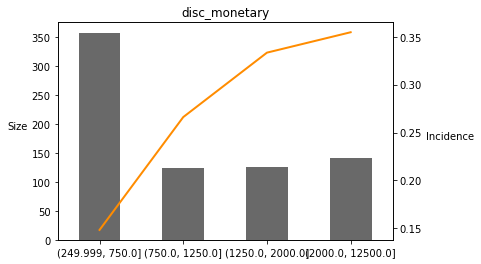

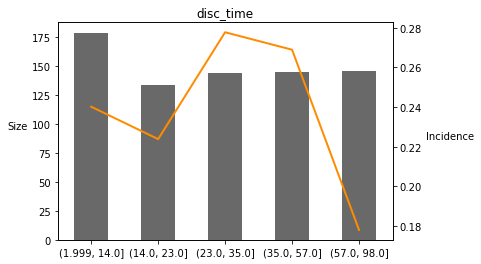

In [107]:
#plot multiple at once
for variable in variables:
    pig_table = create_pig_table(df, 'target', variable)
    plot_pig(pig_table, variable)

#bins with bin size vs. incidence rate for each bin 